
<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/mlab/w1d2_resnet_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOTE: my colab version to use the GPU is here: https://colab.research.google.com/drive/1U2JkwkasA2QQLtZPOeGonoiMrnLqQKzE#scrollTo=tgeFbGbAczWr

In [1]:
# Only execute on Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone --depth 1 https://github.com/EffiSciencesResearch/ML4G.git
    !cd ML4G
    !pip install -r /content/ML4G/requirements.txt --quiet
    %cd /content/ML4G/mlab


# W1D2 - as_strided, einsum, and Build Your Own ResNet

ResNet is a architecture named after its residual connections. In the 2015 paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf), the authors demonstrated with a winning solution to ILVSRC 2015 that  residual connections were a solution to the problem of training neural networks with hundreds of layers.

At this time, it was difficult to train networks with more than tens of layers. Even with normalization layers to prevent gradients from vanishing or exploding, and even with robust data augmentation to reduce overfitting, optimizers like SGD struggled to find solutions with low training error, let alone good generalization.

The authors provided empirical evidence that ResNets were effective, and in recent years the theory of residual connections has developed. For example, we now know that [Residual Networks Behave Like Ensembles of Relatively Shallow Networks](https://arxiv.org/pdf/1605.06431.pdf), and that under some conditions ResNets are [guaranteed to converge to a global (not local!) optimum in polynomial time](https://arxiv.org/pdf/1811.03804.pdf).

The ResNet we'll build today is no longer state of the art, but you'll find residual connections appearing again and again throughout the course, so it's worth understanding this idea in detail.

## Table of Contents

- [Readings](#readings)
- [Inference Using a Pre-Trained ResNet](#inference-using-a-pre-trained-resnet)
  - [Gotcha 1 - Training vs Eval Mode](#gotcha----training-vs-eval-mode)
  - [Gotcha 2 - Input Normalization](#gotcha----input-normalization)
  - [Gotcha 3 - no_grad / inference_mode](#gotcha----nograd--inferencemode)
  - [The `tqdm` library](#the-tqdm-library)
- [Loading and Caching Images](#loading-and-caching-images)
- [Torchvision Transforms](#torchvision-transforms)
- [Image Preprocessing](#image-preprocessing)
- [ImageNet Class Names](#imagenet-class-names)
- [Making Predictions (pretrained model)](#making-predictions-pretrained-model)
- [Practice with `einsum` and `as_strided`](#practice-with-einsum-and-asstrided)
  - [Trace of a matrix](#trace-of-a-matrix)
  - [Matrix Multiplication](#matrix-multiplication)
  - [PyTorch's `conv1d` Exercises](#pytorchs-convd-exercises)
  - [Your Own `conv1d`](#your-own-convd)
  - [Your Own `conv2d`](#your-own-convd)
  - [Padding a Tensor](#padding-a-tensor)
  - [Padding and Stride for `conv1d`](#padding-and-stride-for-convd)
  - [Helper functions for pairs](#helper-functions-for-pairs)
  - [Padding and Stride for `conv2d`](#padding-and-stride-for-convd)
- [Max Pooling](#max-pooling)
  - [Module version](#module-version)
  - [Constructor](#constructor)
  - [extra_repr](#extrarepr)
- [Linear Module](#linear-module)
  - [Initialization](#initialization)
- [`Conv2d` - nn.Module version](#convd---nnmodule-version)
- [Batch Normalization](#batch-normalization)
  - [Train and Eval Modes](#train-and-eval-modes)
- [ReLU Module](#relu-module)
- [Sequential](#sequential)
- [Flatten](#flatten)
- [ResNet Average Pooling](#resnet-average-pooling)
- [Assembling ResNet](#assembling-resnet)
  - [Residual Block](#residual-block)
  - [BlockGroup](#blockgroup)
  - [ResNet34](#resnet)
- [Copying Pretrained Weights](#copying-pretrained-weights)
- [Running Your Model](#running-your-model)
- [Training ResNet on CIFAR10](#training-resnet-on-cifar)
  - [Preparing the CIFAR10 Data](#preparing-the-cifar-data)
  - [Train your ResNet](#train-your-resnet)
  - [Test Your ResNet](#test-your-resnet)
- [Bonus](#bonus)
  - [Fused BatchNorm and Conv2d](#fused-batchnorm-and-convd)
  - [Deeper Look at Initialization](#deeper-look-at-initialization)
  - [Residual Block Identity Initialization](#residual-block-identity-initialization)
  - [Data Augmentation](#data-augmentation)
  - [ReLU Benchmarking](#relu-benchmarking)
  - [Negative Strides](#negative-strides)
  - [Adversarial Examples](#adversarial-examples)
  - [Build Your Own Dtype Support](#build-your-own-dtype-support)
  - [Benchmarking Inference Mode](#benchmarking-inference-mode)

## Bonus readings

- [Batch Normalization in Convolutional Neural Networks](https://www.baeldung.com/cs/batch-normalization-cnn)
- [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

## Inference Using a Pre-Trained ResNet

First, we'll load a pre-trained ResNet34 from the [torchvision.models](https://pytorch.org/vision/stable/models.html) package and use it to classify some images. The 34 refers to the number of layers in the model.

There are at least three things that are easy to forget. If you forget these things then your model will still run without any errors, and will likely even perform decently, which makes it tricky to even detect that you've done something wrong. Unfortunately, this is just the reality of working on ML code.

### Gotcha 1 - Training vs Eval Mode

By default, the model is in training mode when loaded, but we want it to be in evaluation mode for inference. This means that `model.training` is True, and for each submodule their corresponding flag like `model.bn1.training` is True as well. Calling `model.eval()` sets the flag to False on the model and recursively on all submodels.

What does this actually do? The two cases you'll need to know for the course are batch normalization and dropout layers.

- Batch normalization in training mode calculates mean and variance based on the current batch, which can be ok-ish or really bad depending on the size of your batches at inference time. In eval mode it uses aggregated statistics saved in the earlier training process.
- Dropout in training mode randomly sets activations to zero and rescales the others. In eval mode it does nothing.

### Gotcha 2 - Input Normalization

The ResNet was trained on images that were normalized using special constants, which are in the PyTorch documentation. It thus expects any images you give it to be also normalized using these special constants. If you forget to do this, you might see the model still gives the right classification, but the logits are small for every class because the image doesn't quite look like anything it was trained on.

Another way I have personally messed this up is if by using images that are already normalized, but you normalize them a second time by mistake.

### Gotcha 3 - no_grad / inference_mode

PyTorch is built around making backpropagation easy, and by default it does some extra work just in case you want to run backpropagation later. This is especially true on tensors that have `requires_grad` set to True, which pretrained model does by default. When you implement your own backpropagation later, you'll understand this in more detail.

We can tell PyTorch not to do any of this extra work by wrapping calls to our model in `with t.inference_mode():` as described in the [PyTorch docs](https://pytorch.org/docs/stable/autograd.html#locally-disabling-gradient-computation).

If you've seen `with t.no_grad():` before, `inference_mode` is a newer feature (released in PyTorch 1.9) that does everything `no_grad` does plus a couple more optimizations.

### The `tqdm` library

The [tqdm](https://pypi.org/project/tqdm/) library provides nice progress bars so you can see how long operations are going to take. It's very easy to use - just wrap your iterable in `tqdm()`. I recommend using `tqdm` for everything in the course that takes more than a couple seconds to run.



In [2]:
import json
import os
import sys
from collections import OrderedDict
from io import BytesIO
from typing import Callable, Optional, Union, List, Tuple
from pathlib import Path
import requests
import torch as t
import torchvision
from einops import rearrange
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image, UnidentifiedImageError
from torch import nn
from torch.nn.functional import conv1d as torch_conv1d
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm.auto import tqdm
import utils
import w1d2_test

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")
images: List[Image.Image] = []

c:\Users\jraldua-veuthey\AppData\Local\miniconda3\envs\ml4good\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Loading and Caching Images

We've provided some sample images; feel free to call `download_image` some URLs of your choice and append them to the `IMAGES` list. It's polite to cache the images locally instead of downloading them every time the notebook is run, to minimize bandwidth usage.

<details>

<summary>I get UnidentifiedImageError when I try to load my own image!</summary>

This usually means the image format isn't supported on your OS and version of the image library. You can try manually converting the image to a common format like JPEG, or just use another image.

</details>



100%|██████████| 10/10 [00:00<00:00, 593.69it/s]


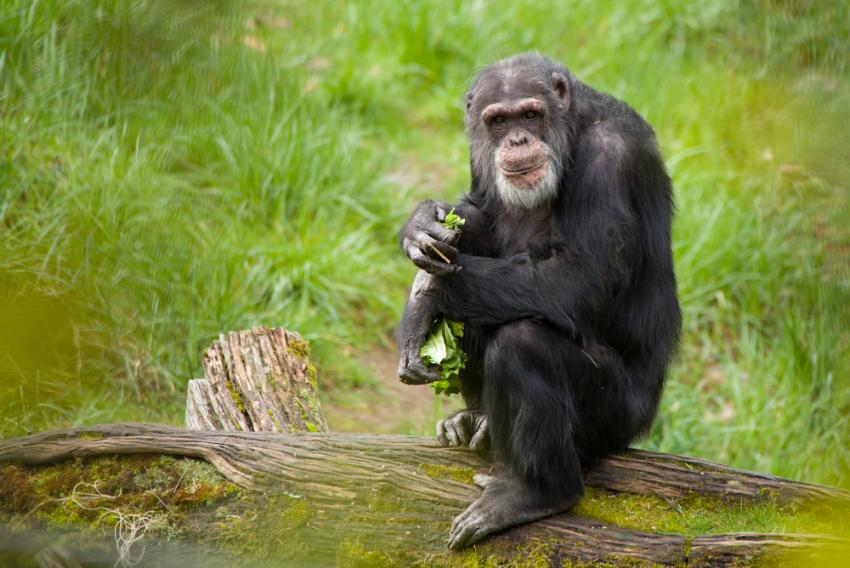

In [3]:
IMAGE_FOLDER = Path("./w1d2_images")
IMAGE_FOLDER.mkdir(exist_ok=True)
IMAGE_FILENAMES = [
    "chimpanzee.jpg",
    "golden_retriever.jpg",
    "platypus.jpg",
    "frogs.jpg",
    "fireworks.jpg",
    "astronaut.jpg",
    "iguana.jpg",
    "volcano.jpg",
    "goofy.jpg",
    "dragonfly.jpg",
]


def download_image(url: str, filename: Optional[str]) -> None:
    """Download the image at url to w1d2_images/{filename}, if not already cached."""
    if filename is None:
        filename = url.rsplit("/", 1)[1].replace("%20", "")
    path = IMAGE_FOLDER / filename
    if not path.exists():
        response = requests.get(url)
        data = response.content
        with path.open("wb") as f:
            f.write(data)


if MAIN:
    images = [Image.open(IMAGE_FOLDER / filename) for filename in tqdm(IMAGE_FILENAMES)]
    if not IS_CI:
        display(images[0])


## Torchvision Transforms

Classes in the `transforms` module are either subclasses of `nn.Module`, or behave similarly in that they are callable. You can compose multiple transforms together with `transforms.Compose` or `nn.Sequential`.

Using the classes in the `transforms` module, we define a variable `preprocess` to be a composition of `transforms.ToTensor`, `transforms.Resize`, and `transforms.Normalize`.

We resize every image to (224, 224) - while the model can support larger images than this, making them all of equal size is necessary for batching.

The normalization constants come from the [documentation](https://pytorch.org/vision/stable/transforms.html)

It's always a good idea to visualize your data after preprocessing to catch any errors, and get a feeling for what the model "sees". You can use [`plt.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) to display a tensor as an image, but you'll need to `rearrange` the data to the format it expects.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


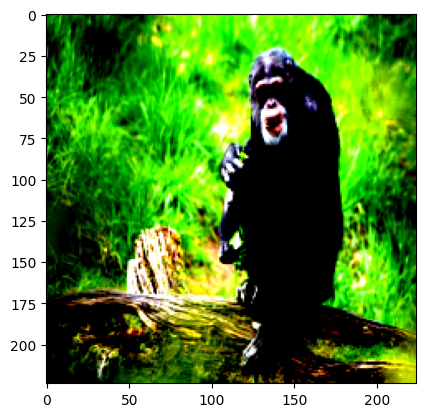

In [4]:
preprocess: Callable[[Image.Image], t.Tensor] 
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

processed: t.Tensor = preprocess(images[0])  # type: ignore
if not IS_CI:
    plt.imshow(rearrange(processed, "c h w -> h w c"))


## Image Preprocessing

Implement `prepare_data` below.


In [5]:
images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=850x568>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x400>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=680x453>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=352x272>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=620x465>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=976x549>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1333x1000>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1111x1389>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x499>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>]

In [6]:
def prepare_data(images: List[Image.Image]) -> t.Tensor:
    """Preprocess each image and stack them into a single tensor.
    Return: shape (batch=len(images), num_channels=3, height=224, width=224)
    """
    # pass
    new_list_images = []
    for image in images:
        processed: t.Tensor = preprocess(image)  # type: ignore
        new_list_images.append(processed)
    out = t.stack(new_list_images, dim=0)
    assert isinstance(out, t.Tensor) and out.shape == (len(images), 3, 224, 224)
    return out

# alternative mlab
# def prepare_data(images: List[Image.Image]) -> t.Tensor:
#     """Preprocess each image and stack them into a single tensor.
#     Return: shape (batch=len(images), num_channels=3, height=224, width=224)
#     """
#     # pass
#     x = t.stack([preprocess(img) for img in tqdm(images)], dim=0)  # type: ignore
#     assert isinstance(x, t.Tensor) and x.shape == (len(images), 3, 224, 224)
#     return x

prepared_images = prepare_data(images)


## ImageNet Class Names

Use the following code to load the class labels for the 1000 classes in ImageNet.

If you haven't encountered ImageNet before, spend a minute looking at the various categories to appreciate just how difficult this classification task is. When we train the model, we give it only 1 correct answer and all the others are considered equally incorrect. For example, given a photo of a dog, knowing that this is a dog or even a terrier is not enough: the model has to distinguish 29 different categories of terrier.

Some of the labels are duplicates for no apparent reason: "laptop computer" is a different category than "notebook computer" and "projectile, missile" is different from "missile". Another issue with the problem setting is that when more than one label truly applies, the model has to infer which one the human labeller had in mind. For example, a scene with a typical desktop PC can contain "desktop computer", "desk", "mouse", "monitor", and "computer keyboard" categories but the labeller would have only specified one of these.


In [7]:
with open("w1d2_imagenet_labels.json") as f:
    imagenet_labels = list(json.load(f).values())


## Making Predictions (pretrained model)

Implement `predict` below and call it with your images. Remember the gotcha discussed above.


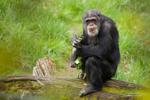

98.3728% chimpanzee, chimp, Pan troglodytes
1.2997% siamang, Hylobates syndactylus, Symphalangus syndactylus
0.0864% guenon, guenon monkey


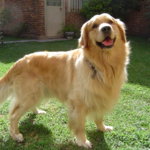

81.8115% golden retriever
2.1947% Sussex spaniel
2.0913% Newfoundland, Newfoundland dog


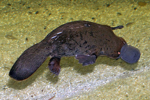

99.9954% platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
0.0023% electric ray, crampfish, numbfish, torpedo
0.0006% stingray


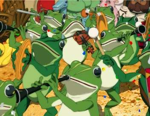

32.9964% toyshop
31.0927% pinwheel
11.3774% comic book


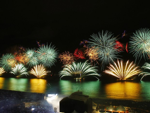

82.3192% fountain
5.3616% pineapple, ananas
4.7077% bearskin, busby, shako


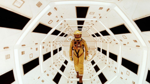

21.6667% liner, ocean liner
10.2838% paddlewheel, paddle wheel
7.9877% vault


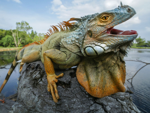

97.6001% common iguana, iguana, Iguana iguana
0.9089% frilled lizard, Chlamydosaurus kingi
0.3256% agama


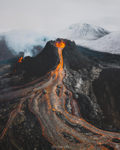

99.9903% volcano
0.0032% alp
0.0026% mountain tent


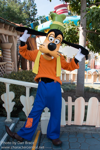

17.9815% binoculars, field glasses, opera glasses
9.4269% picket fence, paling
6.7076% unicycle, monocycle


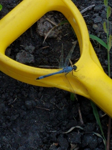

13.6345% bucket, pail
6.1399% banana
5.1396% shovel
[367, 207, 103, 865, 562, 628, 39, 980, 447, 463]


In [8]:
def predict(model, images: List[Image.Image], print_topk_preds=3) -> List[int]:
    """
    Pass the images through the model and print out the top predictions.

    For each image, `display()` the image and the most likely categories according to the model.

    Return: for each image, the index of the top prediction.
    """
    # Gotcha 1 - Training vs Eval Mode
    model.eval()
    # Gotcha 2 - Input Normalization
    prepared_images = prepare_data(images)
    # Gotcha 3 - no_grad / inference_mode
    with t.inference_mode():
        predictions = model(prepared_images)

    ### my solution 
    # most_likely_indices_tensor = predictions.max(dim=1).indices
    # for idx, image in enumerate(images):
    #     display(image)
    #     most_likely_category = imagenet_labels[most_likely_indices_tensor[idx].item()]
    #     print(f"Most likely category for image {str(idx)} is {most_likely_category}")
    # most_likely_indices = predictions.max(dim=1).indices.numpy().tolist()
    
    ### alternative mlab
    probs = predictions.softmax(dim=-1) #do softmax since from the model we get the logits
    assert probs.shape == (len(images), len(imagenet_labels)) #double check the size from the output of the model is ok
    _, indices = predictions.topk(print_topk_preds, dim=-1) #we want the most likely categorIES according to the model

    for i, image in enumerate(images):
        small = image.copy() #fancy image processing that is not obligatory
        small.thumbnail((150, 150)) #fancy image processing that is not obligatory
        display(small) #fancy image processing that is not obligatory
        print("\n".join(f"{100*probs[i][j]:.4f}% {imagenet_labels[j]}" for j in indices[i]))

    most_likely_indices = [ind[0].item() for ind in indices]


    return most_likely_indices


if MAIN and (not IS_CI):
    model = models.resnet34(weights="DEFAULT")
    pretrained_categories = predict(model, images)
    print(pretrained_categories)


## Practice with `einsum` and `as_strided`

Now instead of using torchvision's code for ResNet, we're going to implement our own ResNet! This requires being comfortable with `einsum` and `as_strided`.

If you didn't do the pre-exercises on `as_strided`, it might be worth doing those now. Note that `x.as_strided(...)` is a method equivalent to `torch.as_strided(x, ...)`

### Trace of a matrix

Implement the following functions.


In [9]:
def einsum_trace(a: t.Tensor) -> t.Tensor:
    """Compute the trace of the square 2D input using einsum."""
    # pass
    out = t.einsum('ii -> ', [a]).item()
    return out



if MAIN:
    w1d2_test.test_trace(einsum_trace)
    w1d2_test.test_trace_transpose(einsum_trace)
    w1d2_test.test_trace_expand(einsum_trace)


def as_strided_trace(a: t.Tensor) -> t.Tensor:
    """Compute the trace of the square 2D input using as_strided and sum.

    Tip: the stride argument to `as_strided` must account for the stride of the inputs `a.stride()`.
    """
    # pass
    ### my solution -> wrong but not sure why
    # out = a.as_strided(size=(min(a.size(0), a.size(1)),), stride=(a.size(1) + 1,))
    #     #size=(min(tensor.size(0), tensor.size(1)),) specifies the shape of the resulting tensor view. For a square matrix, tensor.size(0) and tensor.size(1) would be the same, representing the number of rows and columns, respectively. Using min() ensures this code can handle non-square tensors by taking the smaller dimension. The result is a 1D tensor (a vector) whose length is the number of diagonal elements, i.e., the size of the square matrix.
    #     #stride=(tensor.size(1) + 1,) defines the step size for moving between elements in the original tensor to populate the view. In a 2D tensor (matrix), moving from one diagonal element to the next requires skipping over all the elements of one row plus one additional element to reach the next diagonal element. For example, in a 3x3 matrix, moving from the element at index [0,0] to the next diagonal element [1,1] involves moving across one entire row length (3 elements) plus one, hence 3 + 1 = 4. This stride effectively selects the diagonal elements from the original tensor.
    # out = out.sum()

    ### alternative mlab
    N, _ = a.shape # for the size I think it would have been better the solution from chatgpt https://chat.openai.com/share/a26b13b4-9537-461d-a2cc-a73d69255666
    stride = a.stride() # The stride() of a tensor gives you how many elements in the storage you need to skip to get to the next element in each dimension.
    assert len(stride) == 2
    a_strided = a.as_strided(size=(N,), stride=(stride[0] + stride[1],)) # Moving one step in rows and one in columns
    out = t.sum(a_strided)

    return out


if MAIN:
    w1d2_test.test_trace(as_strided_trace)
    w1d2_test.test_trace_transpose(as_strided_trace)
    w1d2_test.test_trace_expand(as_strided_trace)
    a = t.tensor([1]).expand((5, 5))
    a = t.arange(16).reshape((4, 4))

w1d2_test.test_trace passed in 0.01s.
w1d2_test.test_trace_transpose passed in 0.00s.
w1d2_test.test_trace_expand passed in 0.00s.
w1d2_test.test_trace passed in 0.00s.
w1d2_test.test_trace_transpose passed in 0.00s.
w1d2_test.test_trace_expand passed in 0.00s.



### (Bonus) Matrix Multiplication

Implement the following functions.

The implementation of `as_strided_matmul` should do the same thing as `einsum_matmul`, but using only as_strided, product, and sum operations. This is hard, but fun!

<details>

<summary>Hint 1 for as_strided_matmul: description of algorithm</summary>

$$A = \begin{bmatrix}r_1 \\ r_2 \end{bmatrix} \;\;\;\;
B = \begin{bmatrix}c_1 && c_2 && c_3 \end{bmatrix}$$

Where $r_1$ and $r_2$ are row vectors and $c_1$, $c_2$, and $c_3$ are column vectors. All of these vectors should have the same length.

$$A_{repeated} = \begin{bmatrix}
 r_1 && r_1 && r_1 \\
 r_2 && r_2 && r_2 \\
\end{bmatrix}$$
$$B_{repeated} = \begin{bmatrix}
 c_1 && c_2 && c_3 \\
 c_1 && c_2 && c_3 \\
\end{bmatrix}$$

$A_{repeated}$ and $B_{repeated}$ are both 3-tensors. You can imagine the $r$ and $c$ vectors as "going into the page" if that's helpful.

These vectors are now lined up to do elementwise dot products to get the product of the original matrices.

$$A \times B = \begin{bmatrix}
 r_1 \cdot c_1 && r_1 \cdot c_2 && r_1 \cdot c_3 \\
 r_2 \cdot c_1 && r_2 \cdot c_2 && r_2 \cdot c_3 \\
\end{bmatrix}$$

</details>

<details>
<summary>Hint 2 for as_strided_matmul: using as_strided for repititions</summary>
You can use a stride of 0 in as_strided to repeat along that dimension.
</details>

<details>
<summary>Hint 3 for as_strided_matmul: Reading from non-contiguous tensors</summary>
It's possible that the input matrices you recieve could themselves be the output of an as_strided operation, so that they're represented in memory in a non-contiguous way.
Make sure that your as_strided operation is using the strides from the original input matrix on the dimensions that aren't being repeated.
</details>


In [18]:
def einsum_matmul(a: t.Tensor, b: t.Tensor) -> t.Tensor:
    """Matrix multiply 2D matrices a and b (same as a @ b)."""
    # pass

    out = t.einsum('ik,kj->ij',[a,b])
    return out


if MAIN:
    w1d2_test.test_matmul(einsum_matmul)
    w1d2_test.test_matmul_transpose(einsum_matmul)
    w1d2_test.test_matmul_expand(einsum_matmul)
    w1d2_test.test_matmul_skip(einsum_matmul)




w1d2_test.test_matmul passed in 0.00s.
w1d2_test.test_matmul_transpose passed in 0.00s.
w1d2_test.test_matmul_expand passed in 0.00s.
w1d2_test.test_matmul_skip passed in 0.00s.


In [19]:
def as_strided_matmul(a: t.Tensor, b: t.Tensor) -> t.Tensor:
    """Matrix multiply 2D matrices a and b (same as a @ b), but use as_strided this time.

    Use elementwise multiplication and sum.

    Tip: the stride argument to `as_strided` must account for the stride of the inputs `a.stride()` and `b.stride()`.
    """
    # pass

    ### my solution -> does not work
    a_strides = a.stride()
    b_strides = b.stride()
    a_strided = t.as_strided(a, size=(2,a.size(0),a.size(1)),stride=(1,a_strides[0],a_strides[1]))
    b_strided = t.as_strided(b, size=(2,b.size(0),b.size(1)),stride=(b_strides[0],b_strides[1]))

    out = a_strided*b_strided

    ### alternative mlab -> I do not understand it
    A0, A1 = a.shape
    B0, B1 = b.shape
    assert A1 == B0

    AS = a.stride()
    assert len(AS) == 2
    BS = b.stride()
    assert len(BS) == 2
    # Naive version of stride A1, 1, 0 is flawed
    a_strided = a.as_strided(size=(A0, A1, B1), stride=(AS[0], AS[1], 0))
    b_strided = b.as_strided(size=(A0, A1, B1), stride=(0, BS[0], BS[1]))
    out = (a_strided * b_strided).sum(dim=1)

    return out


if MAIN:
    w1d2_test.test_matmul(as_strided_matmul)
    w1d2_test.test_matmul_transpose(as_strided_matmul)
    w1d2_test.test_matmul_expand(as_strided_matmul)
    w1d2_test.test_matmul_skip(as_strided_matmul)

TypeError: 'tuple' object is not callable

## Convolutions

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "kernel") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the kernel and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the kernel sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

![alt text](https://github.com/EffiSciencesResearch/ML4G/blob/main/.images/1d_conv.jpeg?raw=true)

We will also implement 2d convolution, in which the kernel slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

![alt text](https://github.com/EffiSciencesResearch/ML4G/blob/main/.images/2d_conv.png?raw=true)


### PyTorch's `conv1d` Exercises

PyTorch's `conv1d` operates on 3D tensors, and it's easy to get confused on the shapes involved. To practice, for each test, `reshape` the variable `fix_me` so that the output of the `torch_conv1d` call matches the expected tensor.

From the docs:

- The "input" arg to conv1d should be shape (batch_size, in_channels, in_len)
- The "weight" arg should be shape (out_channels, in_channels, kernel_width)
- The output of this function will be shape (batch_size, out_channels, out_len), where out_len will be in_len - kernel_width + 1 (if stride is 1)

In these problems, we'll give you two of these three tensors. You can infer the correct shape for the other one, and reshape it accordingly.

Reminder: when there are multiple output channels, each output channel is computed independently as a function of _all_ the input channels.

<details>

<summary>Solution to A</summary>

The input is (batch=1, in_channels=1, width=4).
The output should be (batch=1, out_channels=1, out_width=3).

The weights should be size (out_channels, in_channels, kernel_width), i.e. (1, 1, 2)

</details>

<details>

<summary>Solution to B</summary>

This is a convolution with a width-1 kernel that spans both input channels, producing 1 output channel

The weights have (out_channels=1, in_channels=2, kernel_width=1)
The output has (batch=2, out_channels=1, out_width=3)

For the input shape, use `out_width = width - kernel_width + 1` to solve `width=3`. So it should be (2, 2, 3)

</details>

<details>

<summary>Solution to C</summary>

This is a convolution with two filters (i.e. two output channels), each of which operate independently on the single input channel.

The weights have (out_channels=2, in_channels=1, kernel_width=1)
The output has (batch=6, out_channels=2, out_width=1)

For the input shape, use `out_width = width - kernel_width + 1` to solve `width=1`. So it should be shape (6, 1, 1)
</details>


A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

In [21]:
# Tip: print the shapes of the input, weights and expected and reason about the shapes, not the numbers.
if MAIN:
    # Hint: From above, the "weight" arg should be shape (out_channels, in_channels, kernel_width)
    input = t.tensor([[[1, 2, 3, 4]]])
    fix_me = t.tensor([[[1, 3]]])
    actual = torch_conv1d(input, fix_me)
    expected = t.tensor([7.0, 11.0, 15.0])
    utils.test_is_equal(actual, expected, "w1d2_test.conv1d_a")
# Bonus
if MAIN:
    fix_me = t.arange(12).reshape(2,2,3)
    weights = t.tensor([[[1], [-1]]])
    actual = torch_conv1d(fix_me, weights)
    expected = t.tensor([[[-3, -3, -3]], [[-3, -3, -3]]])
    utils.test_is_equal(actual, expected, "w1d2_test.conv1d_b")
if MAIN:
    fix_me = t.arange(6).reshape(6,1,1)
    weights = t.tensor([[[-1]], [[1]]])
    actual = torch_conv1d(fix_me, weights)
    expected = t.tensor([[[0], [0]], [[-1], [1]], [[-2], [2]], [[-3], [3]], [[-4], [4]], [[-5], [5]]])
    utils.test_is_equal(actual, expected, "w1d2_test.conv1d_c")


w1d2_test.conv1d_a passed in 0.00s.
w1d2_test.conv1d_b passed in 0.00s.
w1d2_test.conv1d_c passed in 0.00s.



### Your Own `conv1d`

Now implement your own minimal (i.e. assume padding = 0 and stride = 1) version of `conv1d`. It should use an `einsum` and an `as_strided` with careful consideration of the input strides.

<details>
<summary>Hint 1 - creating strided x</summary>
You should use as_strided to make a strided version of x, which should have the shape (batch, input_channels, output_width, kernel_width).

Like we did before, the output width can be calculated as `input_width - kernel_width + 1`.

When you do as_strided, make sure to use appropriate stride values from x.stride().
</details>

<details>
<summary>Hint 2 - using strided x and the weights to get the final output</summary>
You should use einsum on your strided version of x and the input weights to get your final output. You should contract (elementwise product and then sum) over the input channels and kernel width.
</details>


In [ ]:


def conv1d_minimal(x: t.Tensor, weights: t.Tensor) -> t.Tensor:
    """Like torch's conv1d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    """
    pass


if MAIN:
    w1d2_test.test_conv1d_minimal(conv1d_minimal)


### Your Own `conv2d`

Now write your own 2D version. Reminder: the 2 in 2D means the weights slide over the input in two independent dimensions. The inputs and weights, and outputs will all be 4D.

<details>

<summary>Hint 1 - shape of strided x</summary>

The shape of `x` strided should be: (batch, in_channels, output_height, output_width, kernel_height, kernel_width)

We can generalize our 1D output shape calculation to 2D as follows: `output_height = input_height - kernel_height + 1` and `output_width = input_width - kernel_width + 1`.

</details>

<details>

<summary>Hint 2 - strides of strided x</summary>

The first four strides are the strides of the original `x`.
For the kernel_height dimension, increasing by 1 means we want to increase by 1 in the height of `x`, so it should be `x.stride()[2]` and similarly for the kernel_width dimension.
</details>

<details>
<summary>Hint 3 - final einsum</summary>
The einsum should contract (elementwise product and then sum) over the input channels, kernel height, and kernel width dimensions.
</details>

<details>
<summary>Why does my version give slightly different output when using float32 compared to PyTorch's version?</summary>

In floating point, addition is not associative: the sum of two `float32` is generally not representable exactly as a `float32`, so the sum has to be rounded. This means the order that the implementation performs reductions will affect the final result. For example, summing out a vector of four elements could be done from left to right like this:

`((x[0] + x[1]) + x[2]) + x[3]`

Or it could be done recursively like this:

`(x[0] + x[1]) + (x[2] + x[3])`

It's also possible for an implementation to use an accumulator variable of higher precision, and only round at the end which produces different results.
</details>


In [ ]:
def conv2d_minimal(x: t.Tensor, weights: t.Tensor) -> t.Tensor:
    """Like torch's conv2d using bias=False and all other keyword arguments left at their default values.

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)

    Returns: shape (batch, out_channels, output_height, output_width)
    """
    pass


if MAIN:
    w1d2_test.test_conv2d_minimal(conv2d_minimal, t.float64, 1e-10)
    w1d2_test.test_conv2d_minimal(conv2d_minimal, t.float32, 0.001)


### Padding a Tensor

For `conv` and the following `maxpool` you'll need to implement `pad` helper functions. PyTorch has some very generic padding functions, but to keep things simple and build up gradually, we'll write 1D and 2D functions individually.

Tip: use the `new_full` method of the input tensor. This is a clean way to ensure that the output tensor is on the same device as the input.


In [ ]:

def pad1d(x: t.Tensor, left: int, right: int, pad_value: float) -> t.Tensor:
    """Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, width), dtype float32

    Return: shape (batch, in_channels, left + right + width)
    """
    pass


if MAIN:
    w1d2_test.test_pad1d(pad1d)
    w1d2_test.test_pad1d_multi_channel(pad1d)


def pad2d(x: t.Tensor, left: int, right: int, top: int, bottom: int, pad_value: float) -> t.Tensor:
    """Return a new tensor with padding applied to the edges.

    x: shape (batch, in_channels, height, width), dtype float32

    Return: shape (batch, in_channels, top + height + bottom, left + width + right)
    """
    pass


if MAIN:
    w1d2_test.test_pad2d(pad2d)
    w1d2_test.test_pad2d_multi_channel(pad2d)


### Padding and Stride for `conv1d`

Now extend `conv1d` to handle the `stride` and `padding` arguments.

`stride` is the number of input positions that the kernel slides at each step.
`padding` is the number of zeros concatenated to each side of the input before the convolution.

Output shape should be (batch, output_channels, output_length), where output_length can be calculated as follows:
$$
\text{output\_length} = \left\lfloor\frac{\text{input\_length} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Verify for yourself that the forumla above simplifies to the formula we used earlier when padding is 0 and stride is 1.

Docs for pytorch's conv1d can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

<details>
<summary>Hint - how to use the stride argument</summary>
When you perform as_strided on the input, there are two output dimensions that are derived from x.stride()[-1]. One of them should use this value without modification; the other one will use this value multiplied by the stride argument.
</details>


In [ ]:

def conv1d(x, weights, stride: int = 1, padding: int = 0) -> t.Tensor:
    """Like torch's conv1d using bias=False.

    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)

    Returns: shape (batch, out_channels, output_width)
    """
    pass


if MAIN:
    w1d2_test.test_conv1d(conv1d)


### Helper functions for pairs

A recurring pattern in these 2d functions is allowing the user to specify either an int or a pair of ints for an argument: examples are stride and padding. We've provided some type aliases and a helper function to simplify working with these.


In [ ]:
from typing import Tuple
IntOrPair = Union[int, Tuple[int, int]]
Pair = Tuple[int, int]


def force_pair(v: IntOrPair) -> Pair:
    """Convert v to a pair of int, if it isn't already."""
    if isinstance(v, tuple):
        if len(v) != 2:
            raise ValueError(v)
        return (int(v[0]), int(v[1]))
    elif isinstance(v, int):
        return (v, v)
    raise ValueError(v)


### Padding and Stride for `conv2d`

Note the type signature: stride and padding can be either a single number or a tuple for each sliding dimension.


In [ ]:
def conv2d(x, weights, stride: IntOrPair = 1, padding: IntOrPair = 0) -> t.Tensor:
    """Like torch's conv2d using bias=False

    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)


    Returns: shape (batch, out_channels, output_height, output_width)
    """
    pass


if MAIN:
    w1d2_test.test_conv2d(conv2d, t.float64, 1e-10)
    w1d2_test.test_conv2d(conv2d, t.float32, 0.001)


## (Bonus) Max Pooling

A "max pooling" layer is similar to a convolution in that you have a window sliding over some number of dimensions. The main difference is that there's no kernel: instead of multiplying by the kernel and adding, you just take the maximum.

The way multiple channels work is also different. A convolution has some number of input and output channels, and each output channel is a function of all the input channels. There can be any number of output channels. In a pooling layer, the maximum operation is applied independently for each input channel, meaning the number of output channels is necessarily equal to the number of input channels.

Implement `MaxPool2d` using `torch.as_strided` and `torch.amax` together. Your version should behave the same as the [PyTorch version](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) but only the indicated arguments need to be supported.

<details>

<summary>Help! My forward returns the right shape but wrong values!</summary>

Try using an input with all positive values. Does it work correctly now?

</details>

<details>

<summary>Help! I'm still confused!</summary>

The most common cause of this is a wrong padding value. You used zero for the padding value in your convolution. Here, it should be a value smaller than any valid input value, namely `float('-inf')`. A real implementation would need to care about integer tensors as well, but you can punt on this for today.

</details>


In [ ]:
def maxpool2d(
    x: t.Tensor, kernel_size: IntOrPair, stride: Optional[IntOrPair] = None, padding: IntOrPair = 0
) -> t.Tensor:
    """Like PyTorch's maxpool2d.

    x: shape (batch, channels, height, width)
    stride: if None, should be equal to the kernel size

    Return: (batch, channels, out_height, out_width)
    """
    pass


if MAIN:
    w1d2_test.test_maxpool2d(maxpool2d)


### Module version

You've written the functional form of max pooling - next we'll do the `nn.Module` version. A brief primer on `nn.Module` can be found [here](https://www.notion.so/Subclassing-nn-Module-878cd4a1972a4aca822830e49bbaabf4).

Since this module has no learnable parameters, there's only a few steps to do:

### Constructor

Remember to call `super().__init__()` in all your `Module` subclasses.

Store the input arguments and handle the case where stride is `None`.

It would be possible to validate (ensure `kernel_size` is positive) and standardize all the arguments here (converting ints to tuples, etc) and throw an exception if anything is wrong, which would save users some time instead of waiting until `forward()` throws an exception. We will follow PyTorch in not bothering to do this.

### extra_repr

One consequence of subclassing `nn.Module` is that this method is called when you `repr()` an instance of this class, such as printing it in a REPL or notebook. It should provide a human-readable string representation of the attributes of the module that we might want to know about. In this case, these are provided as arguments to the constructor: `kernel_size`, `stride`, and `padding`. You may want to delegate this to a helper function, since you'll be writing this method for every `Module` you implement today that has arguments. Hint: you can use `getattr(object, name)` to programmatically look up `object.name`.


In [ ]:
def extra_repr(module, arg_names: List[str], kwarg_names: List[str]) -> str:
    reprs = [repr(getattr(module, arg_name)) for arg_name in arg_names] + [
        f"{k}={getattr(module, k)}" for k in kwarg_names
    ]
    return ", ".join(reprs)


class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: IntOrPair, stride: Optional[IntOrPair] = None, padding: IntOrPair = 1):
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Call the functional version of maxpool2d."""
        pass

    def extra_repr(self) -> str:
        """Add additional information to the string representation of this class."""
        # You can use the extra_repr function defined above.
        pass


if MAIN:
    w1d2_test.test_maxpool2d_module(MaxPool2d)
    m = MaxPool2d(3, stride=2, padding=1)
    print(f"Manually verify that this is an informative repr: {m}")


## Linear Module

Implement your own `Linear` module. This is the first `Module` that has learnable weights and biases. What type should these variables be?

<details>

<summary>Solution</summary>

It has to be a `torch.Tensor` wrapped in a `nn.Parameter` in order for `nn.Module` to recognize it. If you forget to do this, `module.parameters()` won't include your `Parameter`, which prevents an optimizer from being able to modify it during training.

</details>

### Initialization

For any layer, initialization is very important for the stability of training: with a bad initialization, your model will take much longer to converge or may completely fail to learn anything. The default PyTorch behavior isn't necessarily optimal and you can often improve performance by using something more custom, but we'll follow it for today because it's simple and works decently well.

Each float in the weight and bias tensors are drawn independently from the uniform distribution on the interval:

$$ -\frac{1}{\sqrt{fan_{in}}}, \frac{1}{\sqrt{fan_{in}}} $$

Where $fan_{in}$ is the number of input features.

<details>

<summary>Help! I get the error 'RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.'</summary>

You should initialize the weight `Tensor` before you wrap it in a `Parameter`, because the `Parameter` sets `requires_grad=True` on its argument and this isn't desirable. We don't actually want to backprop through the initialization.

</details>

For the `forward` method, remember that "..." can be used to represent unnamed dimensions in an einsum. (Docs [here](https://pytorch.org/docs/stable/generated/torch.einsum.html), search for "Ellipsis".)


In [ ]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        """A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        """
        self.in_features = in_features
        self.out_features = out_features
        super().__init__()
        bound = in_features**-0.5
        self.weight = nn.parameter.Parameter(t.empty(out_features, in_features).uniform_(-bound, bound))
        if bias:
            self.bias = nn.parameter.Parameter(t.empty(out_features).uniform_(-bound, bound))
        else:
            self.bias = None

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (*, in_features)
        Return: shape (*, out_features)
        """
        pass

    def extra_repr(self) -> str:
        pass


if MAIN:
    w1d2_test.test_linear_forward(Linear)
    w1d2_test.test_linear_parameters(Linear)
    w1d2_test.test_linear_no_bias(Linear)


## `Conv2d` - nn.Module version

The initialization of the Conv2d is also very important. PyTorch does the same uniform distribution, considering `in_features` to be the number of inputs contributing to each output value: `in_channels * product(kernel_size)`.

Remember to use `force_pair` before using `kernel_size`, `stride`, and `padding`, which could come as ints or pairs to the constructor.


In [ ]:
class Conv2d(t.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: IntOrPair, stride: IntOrPair = 1, padding: IntOrPair = 0
    ):
        """Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        """
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply the functional conv2d you wrote earlier."""
        pass

    def extra_repr(self) -> str:
        """"""
        pass


if MAIN:
    print(f"Manually verify that this is a useful looking repr: {Conv2d(1, 2, (3, 4), padding=5)}")
    w1d2_test.test_conv2d_module(Conv2d)


## (Bonus) Batch Normalization

Previous modules you've implemented have either held no tensors like MaxPool2d, or held learnable parameters like Conv2d. The `BatchNorm2d` has a third category: **buffers**.

Unlike `nn.Parameter`, a buffer is not its own type and does not wrap a `Tensor`. A buffer is just a regular `Tensor` on which you've called [self.register_buffer](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer) from inside a `nn.Module`.

The reason we have a different name for this is to describe how it is treated by various machinery within PyTorch.

- It is normally included in the output of `module.state_dict()`, meaning that `torch.save` and `torch.load` will serialize and deserialize it.
- It is moved between devices when you call `model.to(device)`.
- It IS NOT included in `module.parameters`, so optimizers won't see or modify it. Instead, your module will modify it as appropriate within `forward`.

### Train and Eval Modes

This is your first implementation that needs to care about the value of `self.training`, which is set to True by default, and can be set to False by `self.eval()` or to True by `self.train()`.

In training mode, you should use the mean and variance of the batch you're on, but you should also update a stored `running_mean` and `running_var` on each call to `forward` using the "momentum" argument as described in the PyTorch docs. Your `running_mean` shuld be intialized as all zeros; your `running_var` should be initialized as all ones.

In eval mode, you should use the running mean and variance that you stored before (not the mean and variance from the current batch).

Implement `BatchNorm2d` according to the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Call your learnable parameters `weight` and `bias` for consistency with PyTorch.


In [11]:
class BatchNorm2d(nn.Module):
    running_mean: t.Tensor
    "running_mean: shape (num_features,)"
    running_var: t.Tensor
    "running_var: shape (num_features,)"
    num_batches_tracked: t.Tensor
    "num_batches_tracked: shape ()"

    def __init__(self, num_features: int, eps=1e-05, momentum=0.1):
        """Like nn.BatchNorm2d with track_running_stats=True and affine=True.

        Name the learnable affine parameters `weight` and `bias` in that order.
        Warning: momentum is the oposite of the typical momentum. Read the documentation carefully.
        """
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Normalize each channel.

        Compute the variance using `torch.var(x, unbiased=False)`

        x: shape (batch, channels, height, width)
        Return: shape (batch, channels, height, width)
        """
        pass

    def extra_repr(self) -> str:
        pass


if MAIN:
    w1d2_test.test_batchnorm2d_module(BatchNorm2d)
    w1d2_test.test_batchnorm2d_forward(BatchNorm2d)
    w1d2_test.test_batchnorm2d_running_mean(BatchNorm2d)

AttributeError: 'BatchNorm2d' object has no attribute 'num_features'


## ReLU Module

Write the module version of ReLU using `torch.maximum`. Its constructor has no arguments, so it doesn't need an `extra_repr`.


In [ ]:
class ReLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        pass




## Sequential

[torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) has a number of features, but we'll just implement the basics that we need for today.

Note: the base class's `repr` already recursively prints out the submodules, so you don't need to write anything in `extra_repr`.


In [ ]:
class Sequential(nn.Module):
    def __init__(self, *modules: nn.Module):
        """
        Call `self.add_module` on each provided module, giving each one a unique (within this Sequential) name.
        Internally, this adds them to the dictionary `self._modules` in the base class, which means they'll be included in self.parameters() as desired.
        """
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Chain each module together, with the output from one feeding into the next one."""
        pass


if MAIN:
    w1d2_test.test_sequential(Sequential)
    w1d2_test.test_sequential_forward(Sequential)



## (Bonus) Flatten

Implement your own [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

<details>

<summary>Spoiler - Which function do I use to perform the flattening?</summary>

`torch.reshape` is the best choice since it has the desired behavior: returning a view when possible, otherwise a copy. You could also use `einops.rearrange` but you'd have to construct the rearrangement pattern as a string.

</details>


In [ ]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        pass

    def forward(self, input: t.Tensor) -> t.Tensor:
        """Flatten out dimensions from start_dim to end_dim, inclusive of both.

        Return a view if possible, otherwise a copy.
        """
        pass

    def extra_repr(self) -> str:
        pass


if MAIN:
    w1d2_test.test_flatten(Flatten)
    w1d2_test.test_flatten_is_view(Flatten)



## ResNet Average Pooling

Let's end our collection of `Module`s with an easy one :)

The ResNet has a Linear layer with 1000 outputs at the end in order to produce classification logits for each of the 1000 classes. Any Linear needs to have a constant number of input features, but the ResNet is supposed to be compatible with arbitrary height and width, so we can't just do a pooling operation with a fixed kernel size and stride.

Luckily, the simplest possible solution works decently: take the mean over the spatial dimensions. Intuitively, each position has an equal "vote" for what objects it can "see".


In [ ]:
class AveragePool(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        """
        pass



## Assembling ResNet

Now we have all the building blocks we need to start assembling your own ResNet! The following diagram describes the architecture of ResNet34 - the other versions are broadly similar. Unless otherwise noted, convolutions have a kernel_size of 3x3 and a stride of 1. None of the convolutions have biases. You'll be able to infer the number of input channels by the output of the previous layer, and infer the necessary padding from the input and output shapes.

Exercise: there would be no advantage to enabling biases on the convolutional layers. Why?

<details>

<summary>Solution - Why No Biases?</summary>

Every convolution layer in this network is followed by a batch normalization layer. The first operation in the batch normalization layer is to subtract the mean of each output channel. But a convolutional bias just adds some scalar `b` to each output channel, increasing the mean by `b`. This means that for any `b` added, the batch normalization will subtract `b` to exactly negate the bias term.

</details>

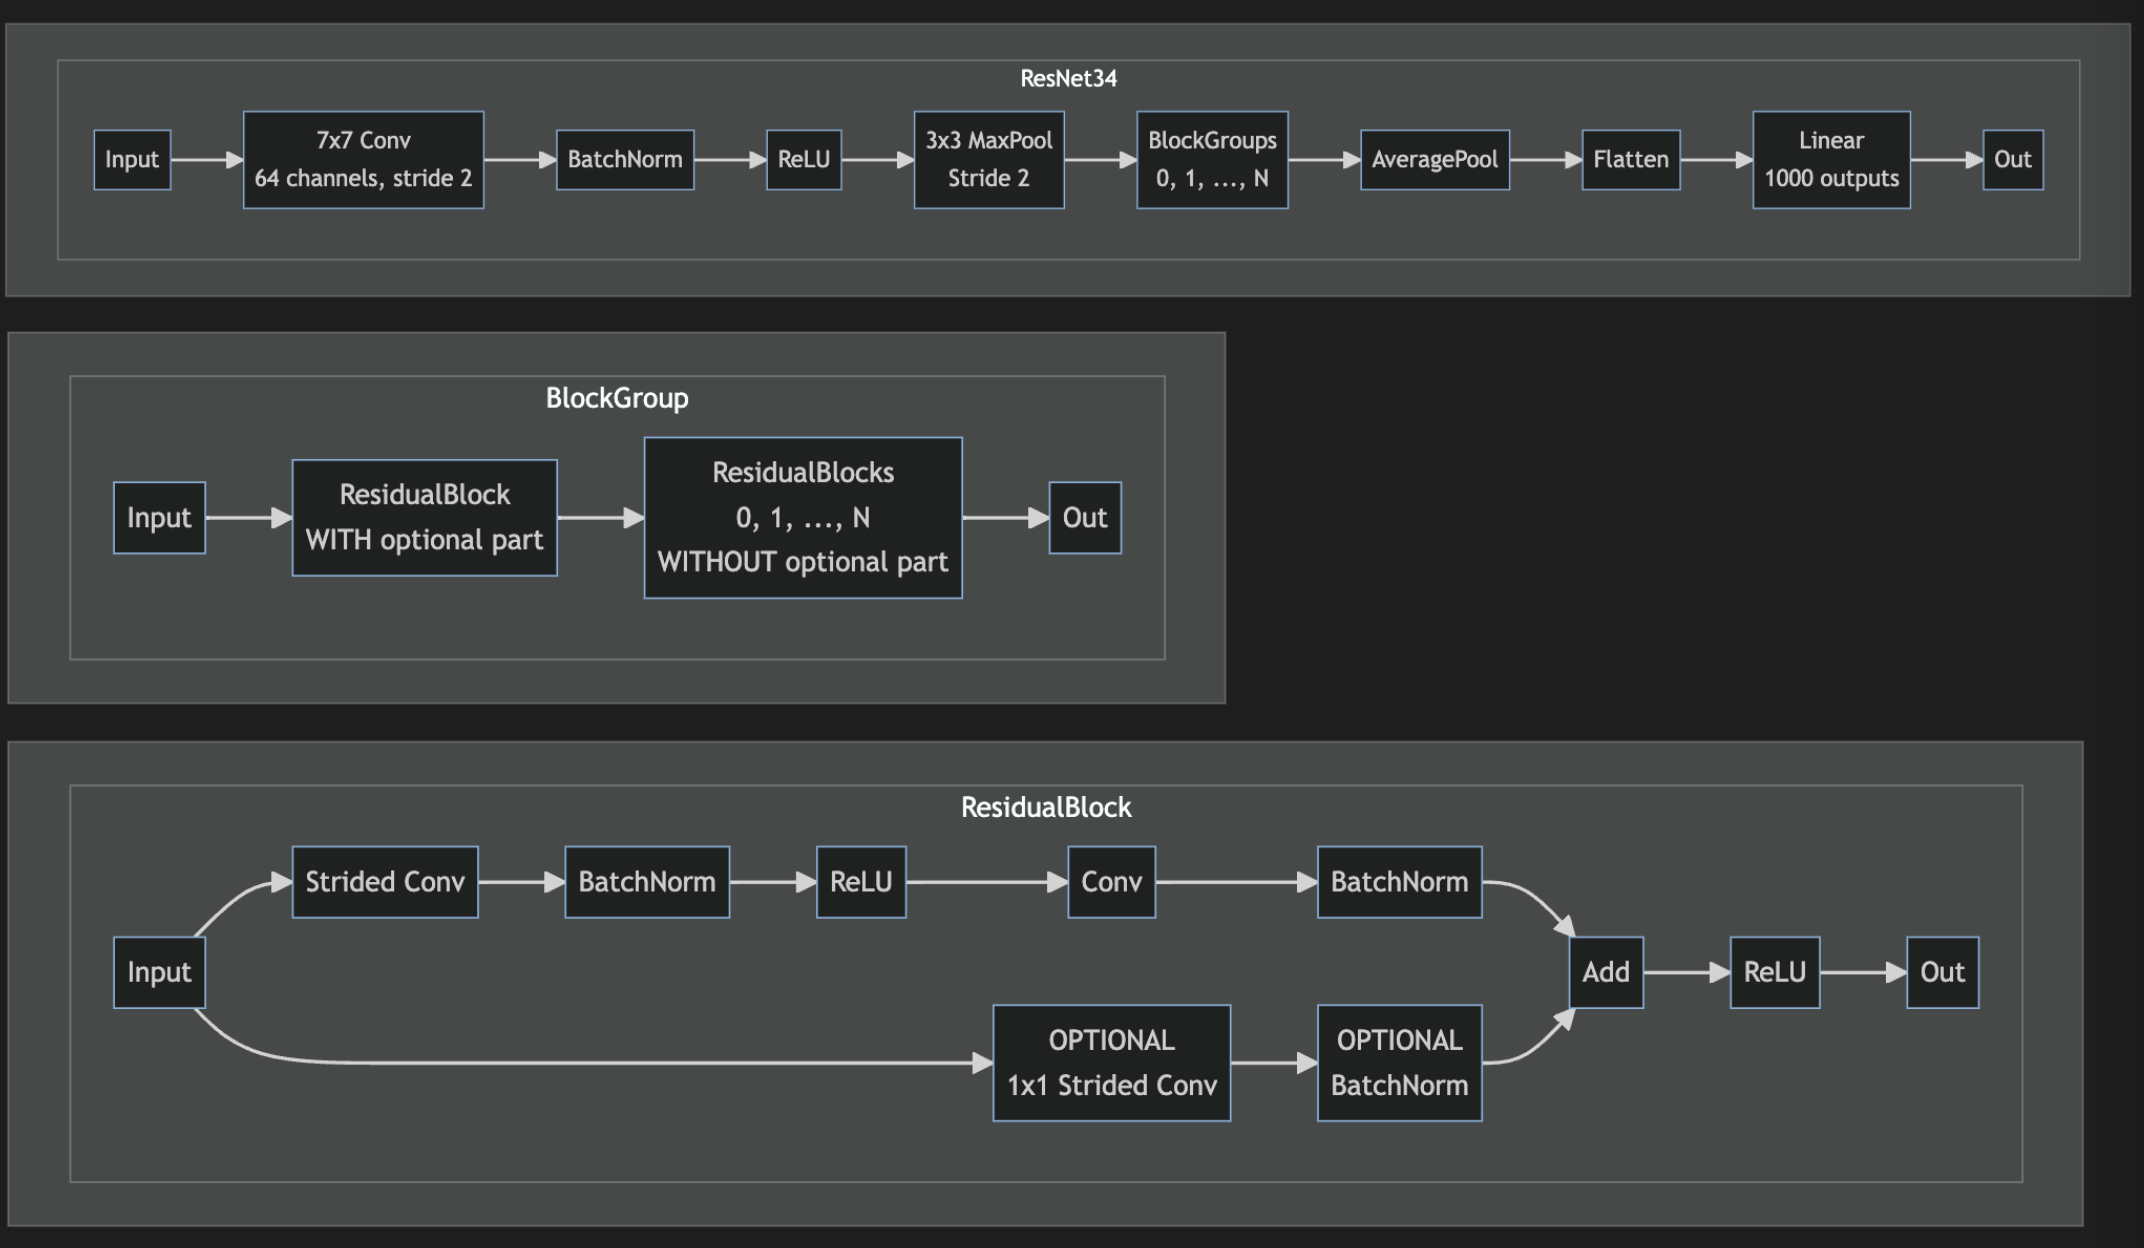

### Residual Block

Implement `ResidualBlock` by referring to the diagram. The number of channels changes from `in_feats` to `out_feats` at the first convolution in each branch.

<details>

<summary>I'm confused about where to apply the stride argument!</summary>

The stride only applies to first convolution in each branch. If you apply it to the second convolution in the left branch, the add won't work because you'll have shrunk the left branch twice.

</details>


In [ ]:
# You can comment this following line if you want to do it the hard way
# by using the classes that you have created above!
from torch.nn import Flatten, Sequential, BatchNorm2d, ReLU, MaxPool2d, Linear, AvgPool2d, Conv2d

# Warning: If you use pytorch's Conv2d, don't forget to add "bias = False" !

class ResidualBlock(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_stride=1):
        """A single residual block with optional downsampling.

        For compatibility with the pretrained model, declare the left side branch first using a `Sequential`.

        If first_stride is > 1, this means the optional (conv + bn) should be present on the right branch. Declare it second using another `Sequential`.
        """
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)

        If no downsampling block is present, the addition should just add the left branch's output to the input.
        """
        pass



### BlockGroup

Implement BlockGroup according to the diagram. The number of channels changes from `in_feats` to `out_feats` at the first convolution in the BlockGroup.


In [ ]:
class BlockGroup(nn.Module):
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride=1):
        """An n_blocks-long sequence of ResidualBlock where only the first block uses the provided stride."""
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Compute the forward pass.
        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        """
        return self.blocks(x)



### ResNet34

Last step! Assemble `ResNet34` using the diagram.


In [ ]:

class ResNet34(nn.Module):
    def __init__(
        self,
        n_blocks_per_group=[3, 4, 6, 3],
        out_features_per_group=[64, 128, 256, 512],
        strides_per_group=[1, 2, 2, 2],
        n_classes=1000,
    ):
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)

        Return: shape (batch, n_classes)
        """
        pass




## Copying Pretrained Weights

Before we go training our ResNet from scratch, let's make sure everything is correct by copying over the weights from the `torchvision` version to yours. We call `state_dict()` on the torchvision model to retrieve its state, and then convert that into a dictionary that you can feed to your model's `load_state_dict`.

We can do this however we want, but way I prefer is to try and build a 1-1 correspondence between the order of the 218 parameters and buffers in the pretrained model and the 218 in yours. Then we can just pair the names from your model with the data from their model. If you've followed the instructions throughout for what order to initialize things in, then this should "just work".

Tip: `load_state_dict` expects an `OrderedDict`, but since Python 3.7, the builtin `dict` is guaranteed to maintain items in the order they're inserted, so we can safely use a regular `dict`.


In [ ]:
if MAIN and (not IS_CI):
    their_model = models.resnet34(pretrained=True)
    your_model = ResNet34()

    their_state = their_model.state_dict().items()
    your_state = your_model.state_dict().items()
    assert len(their_state) == len(your_state), "Differing number of saved state tensors!"

    """I like to see all the names and shapes so I know where they don't line up."""
    import pandas as pd

    df = pd.DataFrame.from_records(
        [(tk, tuple(tv.shape), mk, tuple(mv.shape)) for ((tk, tv), (mk, mv)) in zip(their_state, your_state)],
        columns=["their name", "their shape", "your name", "your shape"],
    )
    with pd.option_context("display.max_rows", None):  # type: ignore
        display(df)

    assert all(x[1].shape == y[1].shape for x, y in zip(their_state, your_state)), "Shapes don't match!"
    d = OrderedDict((yours[0], theirs[1]) for yours, theirs in zip(your_state, their_state))
    your_model.load_state_dict(d, strict=True)


## Running Your Model

Now the moment of truth: call the `predict` function that you wrote way back on an instance of your own `ResNet34` class. If you've done everything correctly, your version should give the same classifications, and the percentages should match at least to a couple decimal places.

If it does, congratulations, you've now run an entire ResNet, using barely any code from `torch.nn`!

If it doesn't, congratulations, you get to practice model debugging! Don't be afraid to call a TA here if you get stuck.

<details>

<summary>Help! My model is predicting roughly the same percentage for every category!</summary>

This can indicate that your model weights are randomly initialized, meaning the weight loading process didn't actually take. Or, you reinitialized your model by accident after loading the weights.

</details>

<details>

<summary>Help! My model is outputting `nan`!</summary>

To debug this, find the first place where `nan` appears. One way to do this is with forward hooks. An example of using hooks is given below.

</details>


In [ ]:
def check_nan_hook(module: nn.Module, inputs, output):
    """Example of a hook function that can be registered to a module."""
    x = inputs[0]
    if t.isnan(x).any():
        raise ValueError(module, x)
    out = output[0]
    if t.isnan(out).any():
        raise ValueError(module, x)


def add_hook(module: nn.Module) -> None:
    """Remove any existing hooks and register our hook.

    Use model.apply(add_hook) to recursively apply the hook to model and all submodules.
    """
    utils.remove_hooks(module)
    module.register_forward_hook(check_nan_hook)


if MAIN and (not IS_CI):
    your_model.apply(add_hook)
    your_model_predictions = predict(your_model, images)
    w1d2_test.test_same_predictions(your_model_predictions)



## (Bonus) Training ResNet on CIFAR10

Next, we'll train our ResNet from scratch, on the GPU.

ImageNet is going to take too long, so we'll use a much smaller dataset called CIFAR10, which has only 10 classes and much smaller images.

### Preparing the CIFAR10 Data

The data preparation is the same as before, so we've provided it to save time. Following good practice, we'll verify that preprocessed data is roughly normalized to mean 0 and std 1, and looks reasonable visually.


In [ ]:
cifar_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}


def get_cifar10():
    """Download (if necessary) and return the CIFAR10 dataset."""
    "The following is a workaround for this bug: https://github.com/pytorch/vision/issues/5039"
    if sys.platform == "win32":
        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context
    "Magic constants taken from: https://docs.ffcv.io/ffcv_examples/cifar10.html"
    mean = t.tensor([125.307, 122.961, 113.8575]) / 255
    std = t.tensor([51.5865, 50.847, 51.255]) / 255
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
    cifar_train = torchvision.datasets.CIFAR10("w1d2_cifar10_train", transform=transform, download=True, train=True)
    cifar_test = torchvision.datasets.CIFAR10("w1d2_cifar10_train", transform=transform, download=True, train=False)
    return (cifar_train, cifar_test)


if MAIN and (not IS_CI):
    (cifar_train, cifar_test) = get_cifar10()
    trainloader = DataLoader(cifar_train, batch_size=512, shuffle=True, pin_memory=True)
    testloader = DataLoader(cifar_test, batch_size=512, pin_memory=True)
if MAIN and (not IS_CI):
    batch = next(iter(trainloader))
    print("Mean value of each channel: ", batch[0].mean((0, 2, 3)))
    print("Std value of each channel: ", batch[0].std((0, 2, 3)))
    (fig, axes) = plt.subplots(ncols=5, figsize=(15, 5))
    for (i, ax) in enumerate(axes):
        ax.imshow(rearrange(batch[0][i], "c h w -> h w c"))
        ax.set(xlabel=cifar_classes[batch[1][i].item()])



### Train your ResNet

We've provided a basic training loop which is far from optimal, but will serve for today. On my GTX 1080Ti, it took 30 seconds per epoch. On a Tesla V100, it took around 20 seconds per epoch. If you don't have access to a GPU, it's going to be pretty slow and you should reduce the number of epochs from the default of 8.

You may encounter some issues running on GPU. The most common issue is if you manually created any tensors, they could be on the wrong device. The PyTorch docs has a section on [creation ops](https://pytorch.org/docs/stable/torch.html#tensor-creation-ops) which has useful functions for dealing with this cleanly including `empty_like` and `zeros_like`.


In [ ]:
MODEL_FILENAME = "./w1d2_resnet34_cifar10.pt"
device = "cuda" if t.cuda.is_available() else "cpu"


def train(trainloader: DataLoader, epochs: int) -> ResNet34:
    model = ResNet34(n_classes=10).to(device).train()
    optimizer = t.optim.Adam(model.parameters())
    loss_fn = t.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for (i, (x, y)) in enumerate(tqdm(trainloader)):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}, train loss is {loss}")
        print(f"Saving model to: {os.path.abspath(MODEL_FILENAME)}")
        t.save(model, MODEL_FILENAME)
    return model


if MAIN and (not IS_CI):
    if os.path.exists(MODEL_FILENAME):
        print("Loading model from disk: ", MODEL_FILENAME)
        model = t.load(MODEL_FILENAME)
    else:
        print("Training model from scratch")
        model = train(trainloader, epochs=8)


### Test Your ResNet

After one epoch, my ResNet achieved 54% accuracy (random guessing would be 10%), train loss of 1.2 and test loss of 1.3.
After eight epochs, it achieved 68% accuracy, train loss of 0.4 and test loss of 1.1. This generalization gap means the model is overfitting. By the end of the course you'll be able to do better than this.


In [ ]:
if MAIN and (not IS_CI):
    model.eval()
    model.apply(add_hook)
    loss_fn = t.nn.CrossEntropyLoss(reduction="sum")
    with t.inference_mode():
        n_correct = 0
        n_total = 0
        loss_total = 0.0
        for (i, (x, y)) in enumerate(tqdm(testloader)):
            x = x.to(device)
            y = y.to(device)
            with t.autocast(device):
                y_hat = model(x)
                loss_total += loss_fn(y_hat, y).item()
            n_correct += (y_hat.argmax(dim=-1) == y).sum().item()
            n_total += len(x)
    print(f"Test accuracy: {n_correct} / {n_total} = {100 * n_correct / n_total:.2f}%")
    print(f"Test loss: {loss_total / n_total}")


## Further Bonus

Congratulations on completing the day's main content! All of the bonus exercises going forward are completely optional, can be done in any order, and nothing later in the course will depend on you having completed them. If you feel uncertain or confused about any of the day's material, it's probably a better idea to just go back and solidify your understanding before tackling these.

### Fused BatchNorm and Conv2d

After a model is trained, it's possible to merge adjacent BatchNorm and Conv2d layers into one operation for a speedup. Try doing this and see how much improvement you get. If you need a hint, [this blog](https://nenadmarkus.com/p/fusing-batchnorm-and-conv/) has the equations followed by solution code.

### Deeper Look at Initialization

We did a pretty basic initialization today. Read up on Xavier and Kaiming initializations, implement one or both, and try some experiments to see if they actually work better on CIFAR10 than the default PyTorch behavior.

### Residual Block Identity Initialization

The ResNet from `torchvision` has a `zero_init_residual` argument. Investigate the source code in `torchvision/models/resnet.py` and see what this does, then replicate it.

### Data Augmentation

One way to reduce overfitting is ensure that the network doesn't see the exact same image more than once. Play with some of the transforms in the torchvision library like random crops and rotations and see if you can reduce the generalization gap.

### ReLU Benchmarking

Predict which of the ReLU functions is fastest on massive tensors, then benchmark them on CPU and GPU. Why do you think some are faster than others?

### Negative Strides

In NumPy, an `ndarray` can have a negative stride which means iterating backward through the underlying storage. For example: `np.flip(np.arange(10))`. What happens when you do the same thing in PyTorch?

<details>

<summary>Solution - Negative Strides In PyTorch</summary>

At least in PyTorch 1.11, `torch.flip` makes a copy instead of a view, and negative strides in `as_strided` throw an error. If you are trying to port code that uses `np.flip` to PyTorch, you will probably have to rewrite those calls otherwise it'll be unexpectedly expensive.

Supporting negative strides in at least some places is an [open issue](https://github.com/pytorch/pytorch/issues/16424) and if the idea of contributing to PyTorch sounds fun to you, this could be a big adventure.

</details>

### Adversarial Examples

Adversarial examples in this context are images that to a human clearly and obviously belong to one class, but the classifier gives a confidently wrong prediction. Either find existing adversarial examples on the Internet and test them on the various sizes of ResNet, or try to create your own adversarial examples that fool your ResNet. You may find the paper [Adversarial Examples Are Not Bugs, They Are Features](https://arxiv.org/pdf/1905.02175.pdf) to be thought-provoking.

### Build Your Own Dtype Support

PyTorch has both integer and floating point datatypes. Go through your modules from today and see if your code does the same thing as PyTorch when different datatypes are involved, and fix your code to behave appropriately.

### Benchmarking Inference Mode

Research what exactly inference mode does, and see if you can detect a difference in speed or memory consumption from using or not using it.
